# Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb

# Loading The Data

In [2]:
df = pd.read_csv('/kaggle/input/advertising-dataset/advertising.csv')
df

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9
...,...,...,...,...
195,38.2,3.7,13.8,7.6
196,94.2,4.9,8.1,14.0
197,177.0,9.3,6.4,14.8
198,283.6,42.0,66.2,25.5


# EDA

In [3]:
#first 5 rows
df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


In [4]:
#shape of the data
df.shape

(200, 4)

In [5]:
#data types of the columns
df.dtypes

TV           float64
Radio        float64
Newspaper    float64
Sales        float64
dtype: object

In [6]:
#statistical information about the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
TV,200.0,147.0425,85.854236,0.7,74.375,149.75,218.825,296.4
Radio,200.0,23.2640,14.846809,0.0,9.975,22.90,36.525,49.6
Newspaper,200.0,30.5540,21.778621,0.3,12.750,25.75,45.100,114.0
Sales,200.0,15.1305,5.283892,1.6,11.000,16.00,19.050,27.0


In [7]:
#check if there are any duplicated rows
df.duplicated().sum()

0

In [8]:
#number of nulls in each column
df.isnull().sum()

TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64

In [9]:
#information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


array([[<Axes: title={'center': 'TV'}>,
        <Axes: title={'center': 'Radio'}>],
       [<Axes: title={'center': 'Newspaper'}>,
        <Axes: title={'center': 'Sales'}>]], dtype=object)

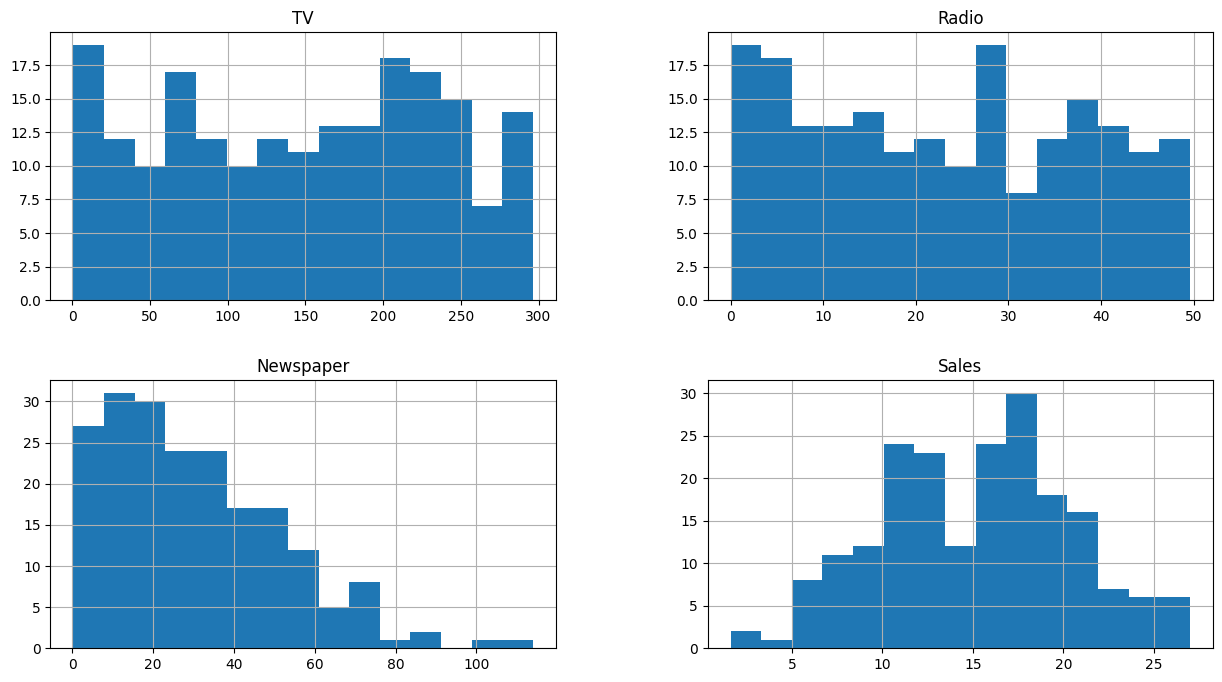

In [10]:
#histograms for all the columns
df.hist(bins = 15, figsize = (15, 8))

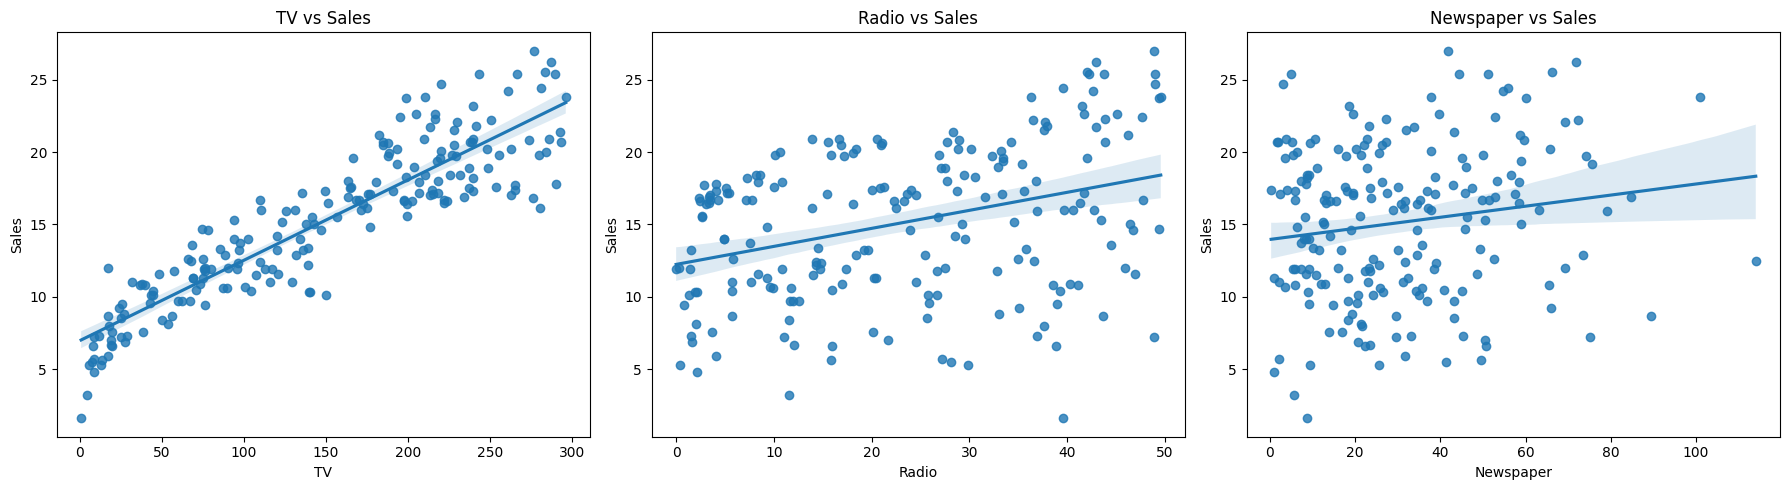

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.regplot(x='TV', y='Sales', data=df, ax=axes[0])
axes[0].set_title('TV vs Sales')

sns.regplot(x='Radio', y='Sales', data=df, ax=axes[1])
axes[1].set_title('Radio vs Sales')

sns.regplot(x='Newspaper', y='Sales', data=df, ax=axes[2])
axes[2].set_title('Newspaper vs Sales')

plt.tight_layout()
plt.show()

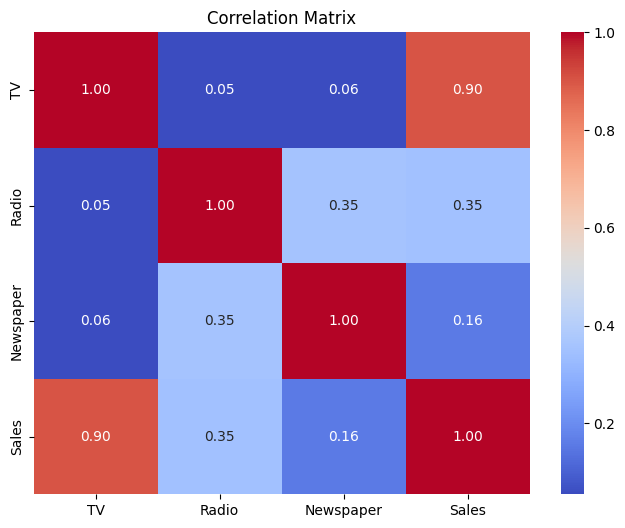

In [12]:
corr = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Data Pre-Processing

In [13]:
#scale the features
features = ['TV', 'Radio', 'Newspaper']
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])
df

,TV,Radio,Newspaper,Sales
0,0.775786,0.762097,0.605981,22.1
1,0.148123,0.792339,0.394019,10.4
2,0.055800,0.925403,0.606860,12.0
3,0.509976,0.832661,0.511873,16.5
4,0.609063,0.217742,0.510994,17.9
...,...,...,...,...
195,0.126818,0.074597,0.118734,7.6
196,0.316199,0.098790,0.068602,14.0
197,0.596212,0.187500,0.053650,14.8
198,0.956713,0.846774,0.579595,25.5


# Modelling

In [14]:
#split data into features and target
X = df.drop(columns=['Sales'])
y = df['Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models and their hyperparameter grids
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': GridSearchCV(estimator=Ridge(), param_grid={'alpha': [0.1, 1, 10, 100]}, cv=5),
    'Lasso Regression': GridSearchCV(estimator=Lasso(), param_grid={'alpha': [0.1, 1, 10, 100]}, cv=5),
    'Decision Tree Regression': GridSearchCV(estimator=DecisionTreeRegressor(), param_grid={'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}, cv=5),
    'Random Forest Regression': GridSearchCV(estimator=RandomForestRegressor(), param_grid={'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}, cv=5),
    'SVR': GridSearchCV(estimator=SVR(), param_grid={'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1, 10], 'kernel': ['rbf']}, cv=5),
    'XGBoost': GridSearchCV(estimator=xgb.XGBRegressor(), param_grid={
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'alpha': [0, 0.1, 1]
    }, cv=5)
}

# Store results
results = []

# Train and evaluate models
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    
    # Predict on training and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Store results
    results.append({
        'Model': name,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train R2': train_r2,
        'Test R2': test_r2
    })
    
    print(f"{name} - Train RMSE: {train_rmse:.6f}, Test RMSE: {test_rmse:.6f}")
    print(f"{name} - Train R2: {train_r2:.6f}, Test R2: {test_r2:.6f}")

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Display results in table format
print("\nResults Table:")
results_df

Training Linear Regression...
Linear Regression - Train RMSE: 1.635892, Test RMSE: 1.705215
Linear Regression - Train R2: 0.900142, Test R2: 0.905901
Training Ridge Regression...
Ridge Regression - Train RMSE: 1.636293, Test RMSE: 1.707447
Ridge Regression - Train R2: 0.900093, Test R2: 0.905655
Training Lasso Regression...
Lasso Regression - Train RMSE: 1.705005, Test RMSE: 1.810350
Lasso Regression - Train R2: 0.891526, Test R2: 0.893940
Training Decision Tree Regression...
Decision Tree Regression - Train RMSE: 0.000000, Test RMSE: 1.875367
Decision Tree Regression - Train R2: 1.000000, Test R2: 0.886185
Training Random Forest Regression...
Random Forest Regression - Train RMSE: 0.466348, Test RMSE: 1.186151
Random Forest Regression - Train R2: 0.991885, Test R2: 0.954469
Training SVR...
SVR - Train RMSE: 1.480739, Test RMSE: 1.344201
SVR - Train R2: 0.918185, Test R2: 0.941527
Training XGBoost...
XGBoost - Train RMSE: 0.513554, Test RMSE: 1.207033
XGBoost - Train R2: 0.990159, Test

,Model,Train RMSE,Test RMSE,Train R2,Test R2
0,Linear Regression,1.635892,1.705215,0.900142,0.905901
1,Ridge Regression,1.636293,1.707447,0.900093,0.905655
2,Lasso Regression,1.705005,1.810350,0.891526,0.893940
3,Decision Tree Regression,0.000000,1.875367,1.000000,0.886185
4,Random Forest Regression,0.466348,1.186151,0.991885,0.954469
5,SVR,1.480739,1.344201,0.918185,0.941527
6,XGBoost,0.513554,1.207033,0.990159,0.952852
